# Probabilistic Modelling Workflow in Turing.jl

Load packages

In [1]:
using Turing, Distributions, Gadfly
using Mamba: describe
srand(1234)
;

In [2]:
x = [(randn(5) .- 5); (randn(5) .+ 5)]

10-element Array{Float64,1}:
 -4.13265
 -5.90174
 -5.49448
 -5.90291
 -4.1356 
  7.21188
  5.53281
  4.72826
  5.50233
  4.48302

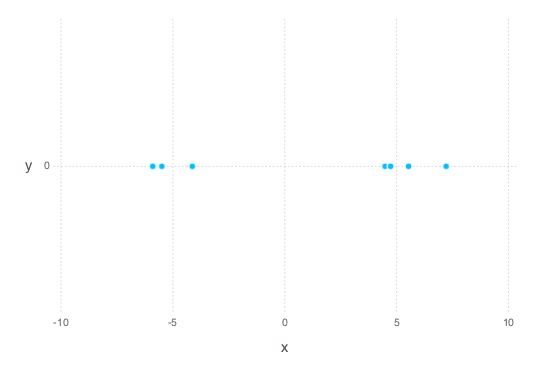

In [3]:
l_x = layer(x=x, y=zeros(length(x)), Geom.point)
plot(l_x)

## Define a very simple Gaussian model
$$ \mu \sim \textit{Normal}(0, 100) $$
$$ x_i \sim \textit{Normal}(\mu, 1), i = 1 \dots N $$

In [4]:
@model g_simple(x) = begin
    m ~ Normal(0, 100)
    for i = 1:length(x)
        x[i] ~ Normal(m, 1)
    end
end

g_simple (generic function with 2 methods)

## Inference by Markov Chain Monte Carlo

In [5]:
chn1 = sample(g_simple(x), HMC(1000, 1.5, 10))

[Turing]:  Assume - `m` is a parameter
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Observe - `x` is an observation
  in @~(::Any, ::Any) at compiler.jl:35


[HMC] Sampling... 28%  ETA: 0:00:07

[HMC] Finished with
  Running time        = 5.033370767;
  Accept rate         = 0.001;
  #lf / sample        = 9.99;
  #evals / sample     = 9.992;


[HMC] Sampling...100% Time: 0:00:05


  pre-cond. diag mat  = [1.0].


Object of type "Turing.Chain"

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

[0.750303 -160.809 0.0 0.00351025; 0.750303 -160.809 0.0 0.00351025; … ; 0.750303 -160.809 0.0 0.00351025; 0.750303 -160.809 0.0 0.00351025]

## Check the statistics of the result

In [6]:
describe(chn1)

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

Empirical Posterior Estimates:
             Mean                      SD                              Naive SE                           MCSE                  ESS   
      m    0.750302734   4.22095850070973721557266×10⁻¹⁵    1.334784277129221763402711×10⁻¹⁶                              0 1000.00000
     lp -160.809070517     1.421796547607490301957×10⁻¹³     4.49611545980369431418922×10⁻¹⁵ 9.4739031434680036625195×10⁻¹⁵  225.22523
 lf_num    0.000000000                                 0                                   0                              0 1000.00000
elapsed    0.003510246 1.8657608504370750690526393×10⁻¹⁷ 5.900053856553920894612019765×10⁻¹⁹                              0 1000.00000

Quantiles:
             2.5%           25.0%          50.0%          75.0%          97.5%    
      m    0.750302734    0.750302734    0.750302734    0.750302734    0.750302734
     lp -160.809070517 -160.809070517

## Visualization

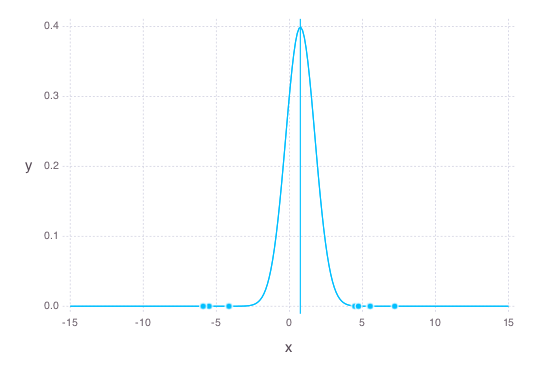

In [7]:
m = mean(chn1[:m])
l_simple_g_mean = layer(xintercept=[m], Geom.vline)
l_simple_g = layer([x->pdf(Normal(m, 1), x)], -15, 15, Geom.line)
plot(l_x, l_simple_g_mean, l_simple_g)

## A better model

$$ \sigma^2 \sim \textit{Inv-Gamma}(2, 3),  \mu \sim \textit{Normal}(0, \sigma) $$
$$ x_i \sim \textit{Normal}(\mu, \sigma), i = 1 \dots N  $$

In [8]:
@model g_better(x) = begin
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    for i = 1:length(x)
        x[i] ~ Normal(m, sqrt(s))
    end
end

g_better (generic function with 2 methods)

In [9]:
chn2 = sample(g_better(x), HMC(1000, 0.2, 4))

[Turing]:  Assume - `s` is a parameter
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `m` is a parameter (ignoring `m` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Observe - `x` is an observation
  in @~(::Any, ::Any) at compiler.jl:35


[HMC] Sampling... 86%  ETA: 0:00:00

[HMC] Finished with
  Running time        = 2.222356753000002;
  Accept rate         = 0.979;
  #lf / sample        = 3.996;
  #evals / sample     = 3.998;
  pre-cond. diag mat  = [1.0,1.0].


[HMC] Sampling...100% Time: 0:00:02


Object of type "Turing.Chain"

Iterations = 1:1000
Thinning interval = 1
Chains = 1
Samples per chain = 1000

[0.445958 -99.5293 … 0.0127689 1.68708; 1.44344 -61.9003 … 0.197052 1316.47; … ; 2.158 -38.8808 … 0.00243614 26.6179; 3.32304 -40.3803 … 0.00267126 20.9118]

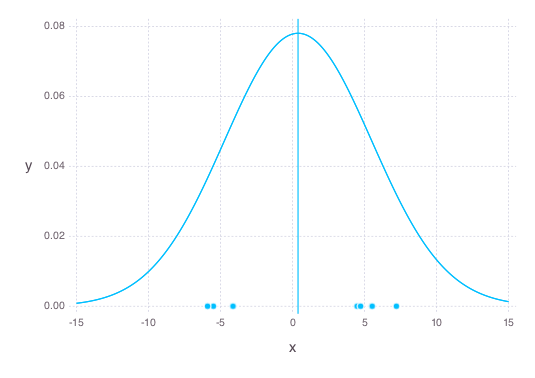

In [10]:
m = mean(chn2[:m])
s = mean(chn2[:s])
l_simple_g_mean = layer(xintercept=[m], Geom.vline)
l_simple_g = layer([x->pdf(Normal(m, sqrt(s)), x)], -15, 15, Geom.line)
plot(l_x, l_simple_g_mean, l_simple_g)

## A even better model - mixture of Gaussians

$$ \sigma^2_k \sim \textit{Inv-Gamma}(2, 3),  \mu_k \sim \textit{Normal}(0, \sigma_k), k = 1 \dots K  $$
$$ z_i \sim \textit{Cat}(K) , x_i \sim \textit{Normal}(\mu_{z_i}, \sigma_{z_i}), i = 1 \dots N  $$

In [11]:
@model g_mix(x) = begin
    s = Vector{Real}(2)
    m = Vector{Real}(2)
    for i = 1:2
        s[i] ~ InverseGamma(2, 3)
        m[i] ~ Normal(0, sqrt(s[i])) 
    end
    z = tzeros(Int, length(x))
    for i = 1:length(x)
        z[i] ~ Categorical(2)
        x[i] ~ Normal(m[z[i]], sqrt(s[z[i]]))
    end
end

g_mix (generic function with 2 methods)

In [12]:
chn3 = sample(g_mix(x), Gibbs(125, HMC(1, 0.2, 4, :s, :m), PG(50, 1, :z)))

[Turing]:  Assume - `s` is a parameter (ignoring `s` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `m` is a parameter (ignoring `m` found in global scope)
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Assume - `z` is a parameter
  in @~(::Any, ::Any) at compiler.jl:56
[Turing]:  Observe - `x` is an observation
  in @~(::Any, ::Any) at compiler.jl:35
[Gibbs] Finished with
  Running time    = 11.446022354999997;


Object of type "Turing.Chain"

Iterations = 1:125
Thinning interval = 1
Chains = 1
Samples per chain = 125

[1.0 1.0 … 2.0 1.0; 1.0 2.0 … 2.0 2.0; … ; 1.0 2.0 … 2.0 1.0; 1.0 2.0 … 2.0 1.0]

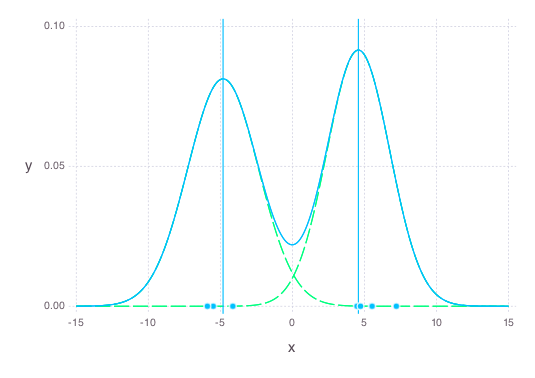

In [13]:
m = mean(chn3[:m][100:end])
s = mean(chn3[:s][100:end])
z = mean(chn3[:z][100:end])
n1 = sum(map(z_ -> abs(z_-1) <  abs(z_-2), z))
n2 = sum(map(z_ -> abs(z_-1) >= abs(z_-2), z))
w = [n1 / 10, n2 / 10]
l_simple_g_mean = layer(xintercept=[m...], Geom.vline)
l_simple_g = layer([x->w[1] * pdf(Normal(m[1], sqrt(s[1])), x) + w[2] * pdf(Normal(m[2], sqrt(s[2])), x)], -15, 15, Geom.line)
l_simple_g_1 = layer([x->w[1] * pdf(Normal(m[1], sqrt(s[1])), x)], -15, 15, Geom.line, Theme(line_style=:dash, default_color=colorant"springgreen"))
l_simple_g_2 = layer([x->w[1] * pdf(Normal(m[2], sqrt(s[2])), x)], -15, 15, Geom.line, Theme(line_style=:dash, default_color=colorant"springgreen"))
plot(l_x, l_simple_g_mean, l_simple_g, l_simple_g_1, l_simple_g_2)